This notebook takes processed mat/pickle files and makes a dataset for prediction.
In particular, given a history and prediction horizon, this generates all viable slices of a full trajectory.  This goes through all pickle files and constructs a dataset for k-fold cross validation.

### TODO
* [ ] optional: complete outlier removal in bag_processing (see "Additional Notes").  Need to check time indices.
* [ ] optional: add metadata to tfrecord (e.g. snippet #, timestamp).

In [1]:
import glob
import numpy as np
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
import pdb
from datetime import datetime
import sklearn.utils as sku
from tqdm import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= "4" 

from pkl_reader import *
from tfrecord_utils import write_tfrecord, read_tfrecord



Using TensorFlow backend.


In [2]:
''' CONFIG: CONSTANTS FOR EXECUTION '''
num_folds_cv = 5 # k-fold cross validation, number of splits (-1 = only provide full set of data)
shuffle = True
seed = 1
prune_start=True          # remove stationary portion of ego's trajectory at the start
prune_end=True            # remove stationary portion of ego's trajectory at the end
min_vel_thresh=0.01       # velocity threshold (m/s) above which ego is considered moving
exclude_collisions=True  # return an empty trajectory if there was a collision

Nhist=5          # number of timesteps of motion history to predict with
Npred=20         # number of timesteps of prediction horizon
Nskip=5          # "stride" for sliding window of snippet selection
dt=0.1           # discretization (s) of full ego trajectory corresponding to N* above
ego_trans = True # whether or not to represent trajectory snippets in the ego frame
                 # if False, use the global map frame for all snippets

In [3]:
save_ext = 'pkl'
file_prefix = '../examples/bags/'
search_str = file_prefix + '*.' + save_ext 
files_to_process = glob.glob(search_str)
print('Found %d files to read: %s' % (len(files_to_process), files_to_process))

Found 57 files to read: ['../examples/bags/parking_p1_t1_e4_2019-11-04-14-36-16.pkl', '../examples/bags/parking_p1_t2_e2_2019-11-04-14-41-42.pkl', '../examples/bags/parking_p3_t2_e5_2019-11-26-16-13-17.pkl', '../examples/bags/parking_p3_t1_e7_2019-11-26-15-47-20.pkl', '../examples/bags/parking_p3_t2_e4_2019-11-26-16-12-49.pkl', '../examples/bags/parking_p2_t1_e9_2019-11-04-16-35-54.pkl', '../examples/bags/parking_p3_t2_e0_2019-11-26-16-11-31.pkl', '../examples/bags/parking_p2_t2_e8_2019-11-04-16-41-53.pkl', '../examples/bags/parking_p1_t2_e5_2019-11-04-14-43-12.pkl', '../examples/bags/parking_p1_t1_e0_2019-11-04-14-34-23.pkl', '../examples/bags/parking_p2_t1_e0_2019-11-04-16-32-53.pkl', '../examples/bags/parking_p2_t2_e4_2019-11-04-16-39-45.pkl', '../examples/bags/parking_p3_t2_e9_2019-11-26-16-14-52.pkl', '../examples/bags/parking_p3_t1_e1_2019-11-26-15-45-22.pkl', '../examples/bags/parking_p3_t1_e2_2019-11-26-15-45-40.pkl', '../examples/bags/parking_p3_t1_e9_2019-11-26-15-48-06.pkl',

In [4]:
def get_parking_lot_image_hist(parking_lot, static_objs, feature, ego_dims):
    # code for the plotting of the parking lot
    ''' 
    Scene Image construction. Resolution/Image Params hardcoded for now.
    '''
    # Get center point (x,y) of the parking lot
    x0 = np.mean([min(x[0] for x in parking_lot),max(x[0] for x in parking_lot)])
    y0 = np.mean([min(x[1] for x in parking_lot),max(x[1] for x in parking_lot)])

    # Parking dimensions we want to consider
    parking_size = [20,65] # dX and dY
    res = 0.1 # in metres
    img_center = [x0,y0] # parking lot center

    h = int(parking_size[1] / res)
    w = int(parking_size[0] / res)

    num_imgs = len(feature)
    img_hist = np.zeros((num_imgs, h, w, 3), dtype=np.uint8)
    img_hist[:,:,:,0] = generate_image(parking_size,res,img_center,parking_lot)
    img_hist[:,:,:,1] = generate_image(parking_size,res,img_center,static_objs)

    for ind_p, ego_pose in enumerate(feature):
        ego_bb = [ego_pose[0],         # x
                  ego_pose[1],         # y
                  ego_dims['length'],  # dx
                  ego_dims['width'],   # dy
                  ego_pose[2]]         # theta

        img_hist[ind_p,:,:,2] = generate_image_ego(parking_size,res,img_center,ego_bb)

    img_hist = np.flip(img_hist, axis=1) # flip based on pixel axis to align with map frame (h)
    return img_hist

In [5]:
num_tfrecords = 0

# full dataset for all files_to_process
features_combined = []
features_global_combined = []
labels_combined = []
goal_snpts_combined = []
static_objs_combined = []

parking_lot = None
ego_dims    = None

for file in files_to_process:
    if save_ext == 'pkl':
        res_dict = pickle.load(open(file,'rb'))
    else:
        raise NotImplemented('Invalid Extension')
    
    goals = extract_goals(res_dict)
    parking_lot = res_dict['parking_lot']
    ego_dims = res_dict['ego_dimensions']
    
    try:
        # parse one demonstration
        ego_trajectory, start_ind, switch_ind, end_ind, goal_ind = \
             extract_full_trajectory(res_dict, goals, prune_start, prune_end, \
                                     min_vel_thresh, exclude_collisions)

        features, features_global, labels, goal_snpts = \
            get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, \
                                           goals, Nhist, Npred, Nskip, dt, ego_frame=ego_trans)
        
        features_combined.extend(features)
        features_global_combined.extend(features_global)
        labels_combined.extend(labels)
        goal_snpts_combined.extend(goal_snpts)
        
        static_object_list = res_dict['static_object_list']
        for i in range(len(features)):
            static_objs_combined.append(static_object_list)
    except ValueError as e:
        print(file, e)
        
if shuffle:
    features_combined, features_global_combined, labels_combined, goal_snpts_combined, static_objs_combined = \
        sku.shuffle(features_combined, features_global_combined, labels_combined, goal_snpts_combined, static_objs_combined, random_state=seed)    

Collisions encountered: 
time 428.591330422
other_id 796 vehicle.nissan.patrol_autopilot
normal_impulse [48.102664947509766, 38.11619567871094, -0.8094014525413513]
time 428.691330427
other_id 796 vehicle.nissan.patrol_autopilot
normal_impulse [46.12480545043945, 36.548954010009766, -0.7761209011077881]
time 428.724663762
other_id 796 vehicle.nissan.patrol_autopilot
normal_impulse [47.58728790283203, 37.70781707763672, -0.800729513168335]
time 428.791330432
other_id 796 vehicle.nissan.patrol_autopilot
normal_impulse [20.486284255981445, 16.233179092407227, -0.3447132706642151]
time 428.791330432
other_id 796 vehicle.nissan.patrol_autopilot
normal_impulse [17.838239669799805, 14.134889602661133, -0.3001558780670166]
time 428.824663767
other_id 796 vehicle.nissan.patrol_autopilot
normal_impulse [38.68595504760742, 30.65446662902832, -0.6509508490562439]
time 428.957997107
other_id 796 vehicle.nissan.patrol_autopilot
normal_impulse [45.07197952270508, 35.71470260620117, -0.758405506610870

In [6]:
N_instances = len(features_combined)
    
if num_folds_cv > 0:
    splits = (N_instances // num_folds_cv) * np.ones(num_folds_cv)
    splits[:N_instances % num_folds_cv] += 1
    
    ind_limits = np.cumsum(splits).astype(np.int)
    
    for i in range(len(ind_limits)):
        if i == 0:
            ind_start = 0
        else:
            ind_start = ind_limits[i-1]
        ind_end = ind_limits[i]
        
        print('Fold', i, ind_start, ind_end)
 
        # write tfrecords in batches from ind_start:ind_end.
        #for j in range(0, ind_end - ind_start, batch_size):
        #    write data from ind_start + j : min(ind_start + j + batch_size, ind_end)
        batch_size = 100 # TODO.
        for batch_ind, j in enumerate(range(ind_start,ind_end,batch_size)):
            j_min = j
            j_max = min(j+batch_size,ind_end)
            
            print('Batch', batch_ind, j_min, j_max)
            
            img_hists_batch = np.array(
                [get_parking_lot_image_hist(parking_lot, 
                                            static_objs_combined[k], 
                                            features_global_combined[k], 
                                            ego_dims) for k in range(j_min, j_max)])
            
            print('Img Hist Shape', img_hists_batch.shape)
            
            file_location = file_prefix + 'dataset_fold_' + str(i) +'_' + str(batch_ind) + '.tfrecord'
            
            print('Saving to ', file_location)
            
            write_tfrecord(features_combined[j_min:j_max],
                           img_hists_batch,
                           labels_combined[j_min:j_max], 
                           goal_snpts_combined[j_min:j_max],
                           file_location, {})

Fold 0 0 347
Batch 0 0 100
Img Hist Shape (100, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_0_0.tfrecord
Batch 1 100 200
Img Hist Shape (100, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_0_1.tfrecord
Batch 2 200 300
Img Hist Shape (100, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_0_2.tfrecord
Batch 3 300 347
Img Hist Shape (47, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_0_3.tfrecord
Fold 1 347 693
Batch 0 347 447
Img Hist Shape (100, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_1_0.tfrecord
Batch 1 447 547
Img Hist Shape (100, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_1_1.tfrecord
Batch 2 547 647
Img Hist Shape (100, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_1_2.tfrecord
Batch 3 647 693
Img Hist Shape (46, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_1_3.tfrecord
Fold 2 693 1039
Batch 0 693 793
Img Hist Shape (100, 5, 650, 200, 3)
Saving to  ../examples/bags/dataset_fold_2_0.tfreco

Instance 0


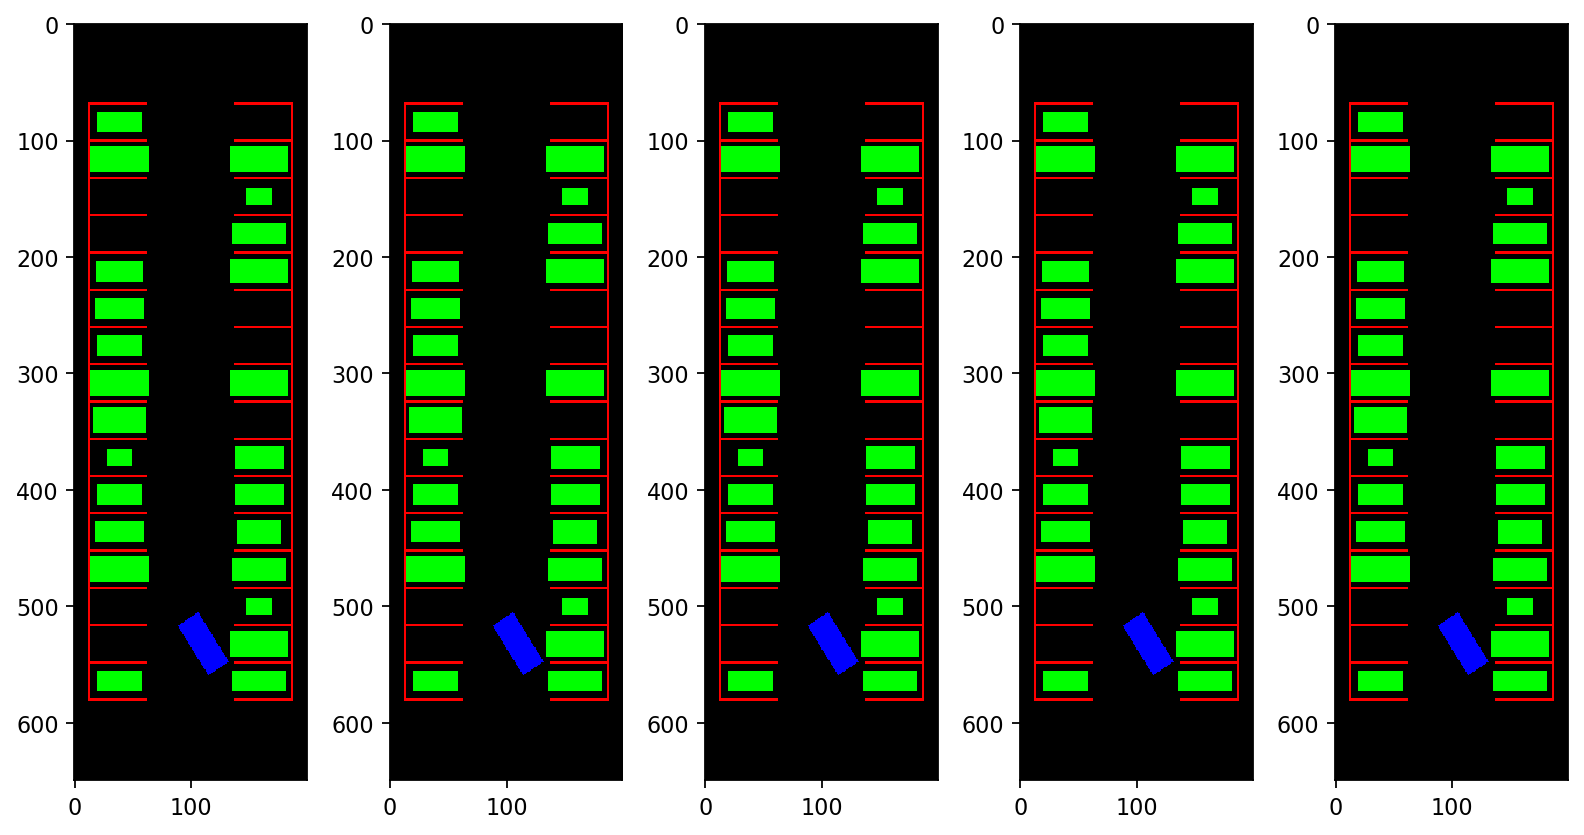

Instance 1


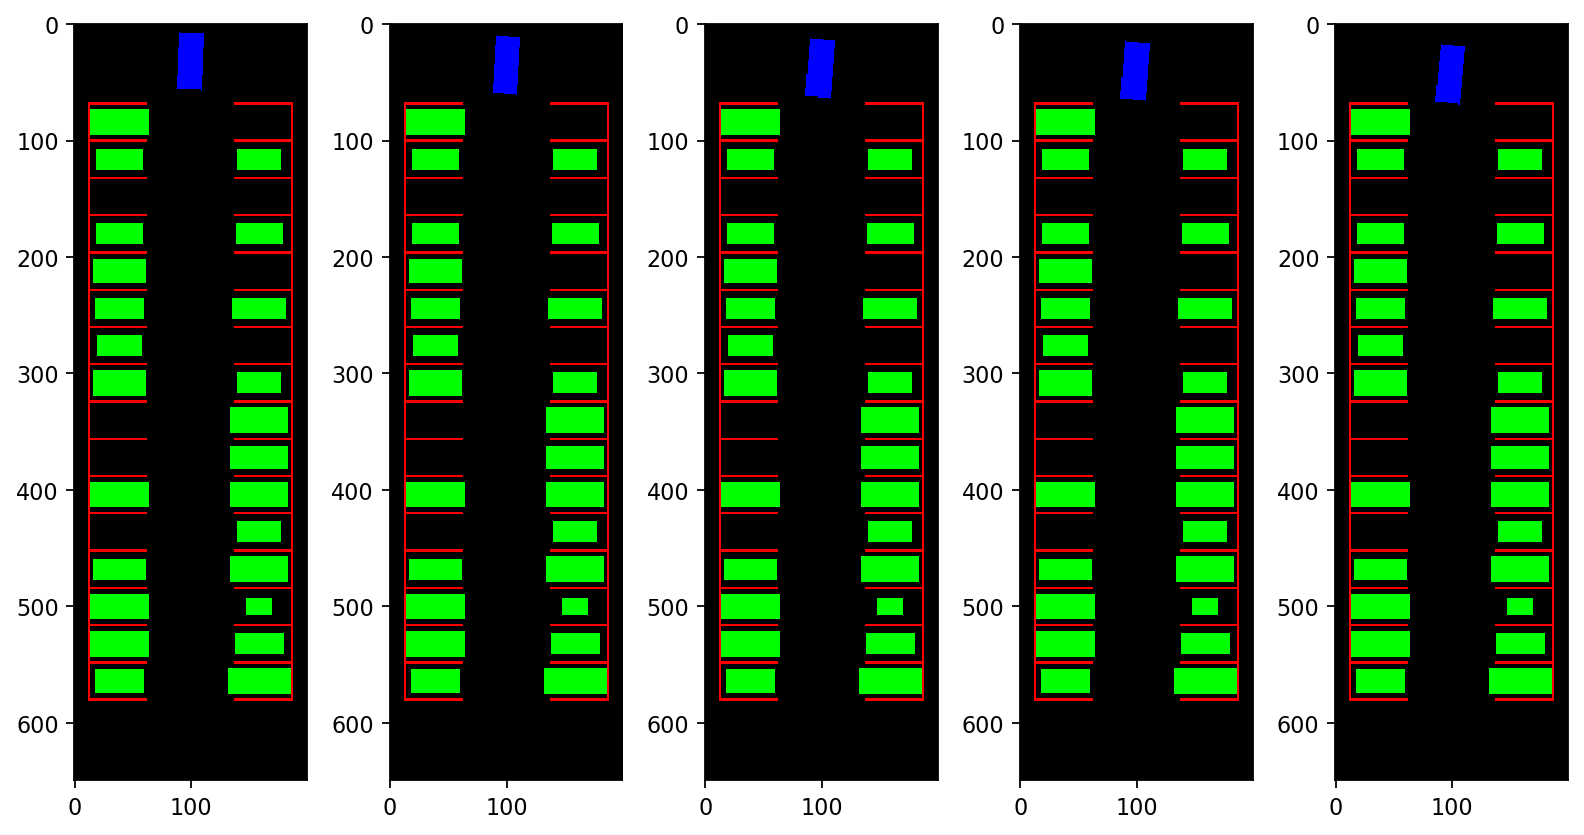

Instance 2


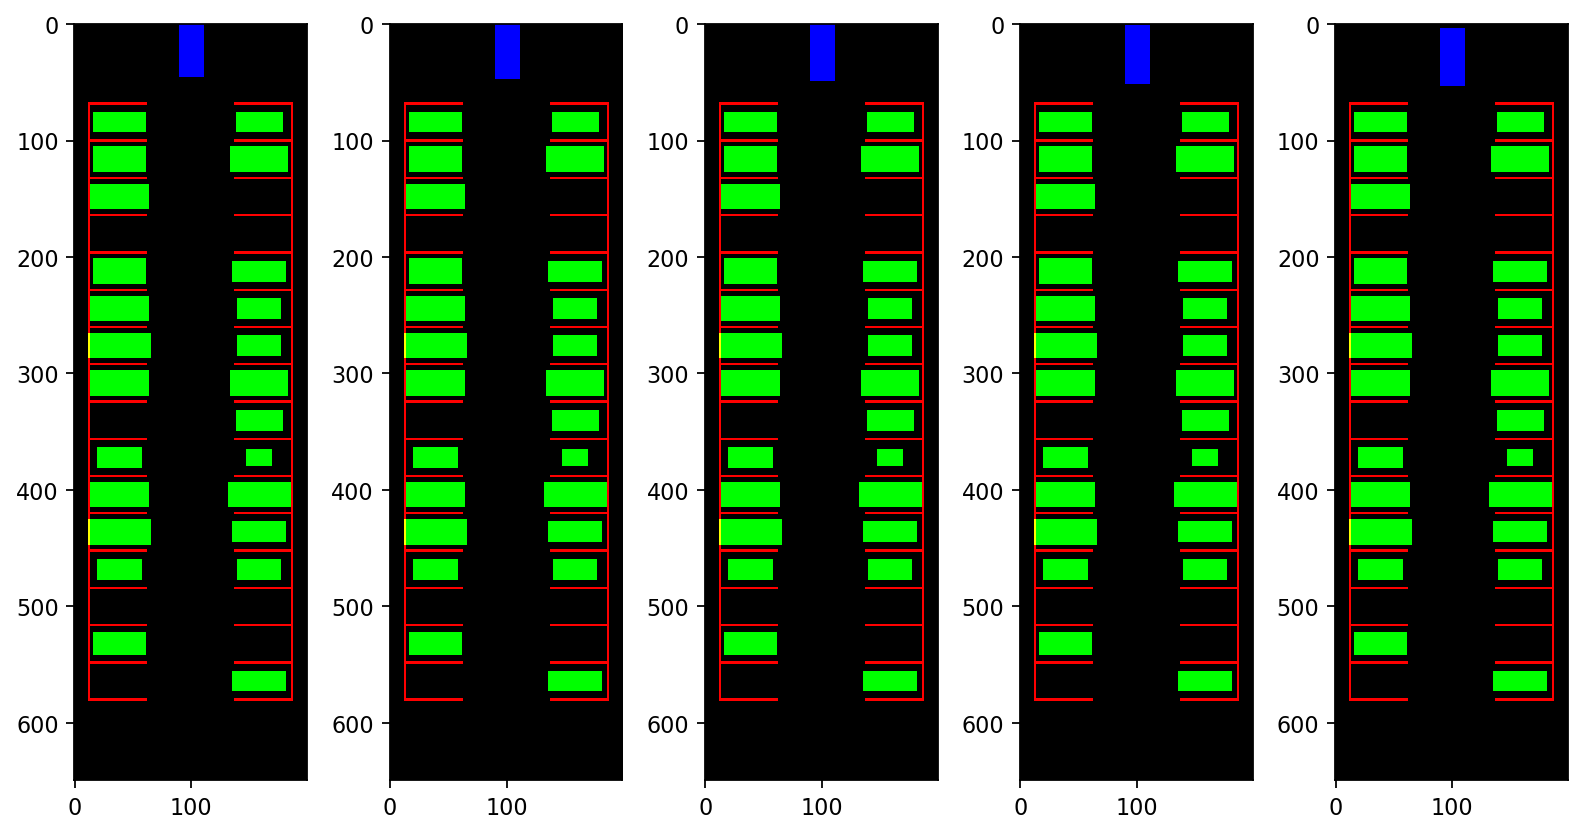

Instance 3


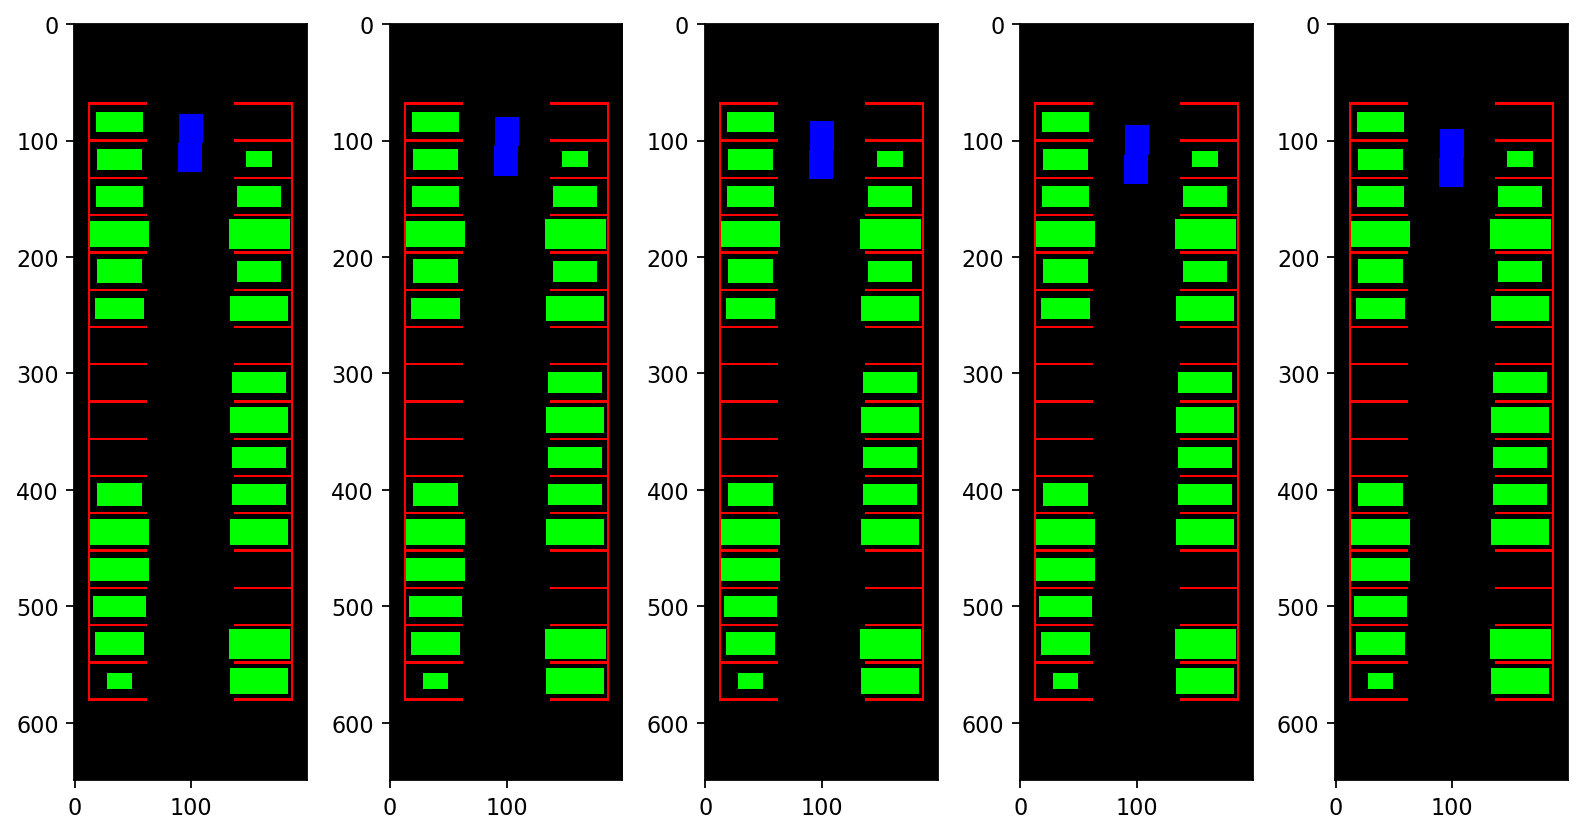

Instance 4


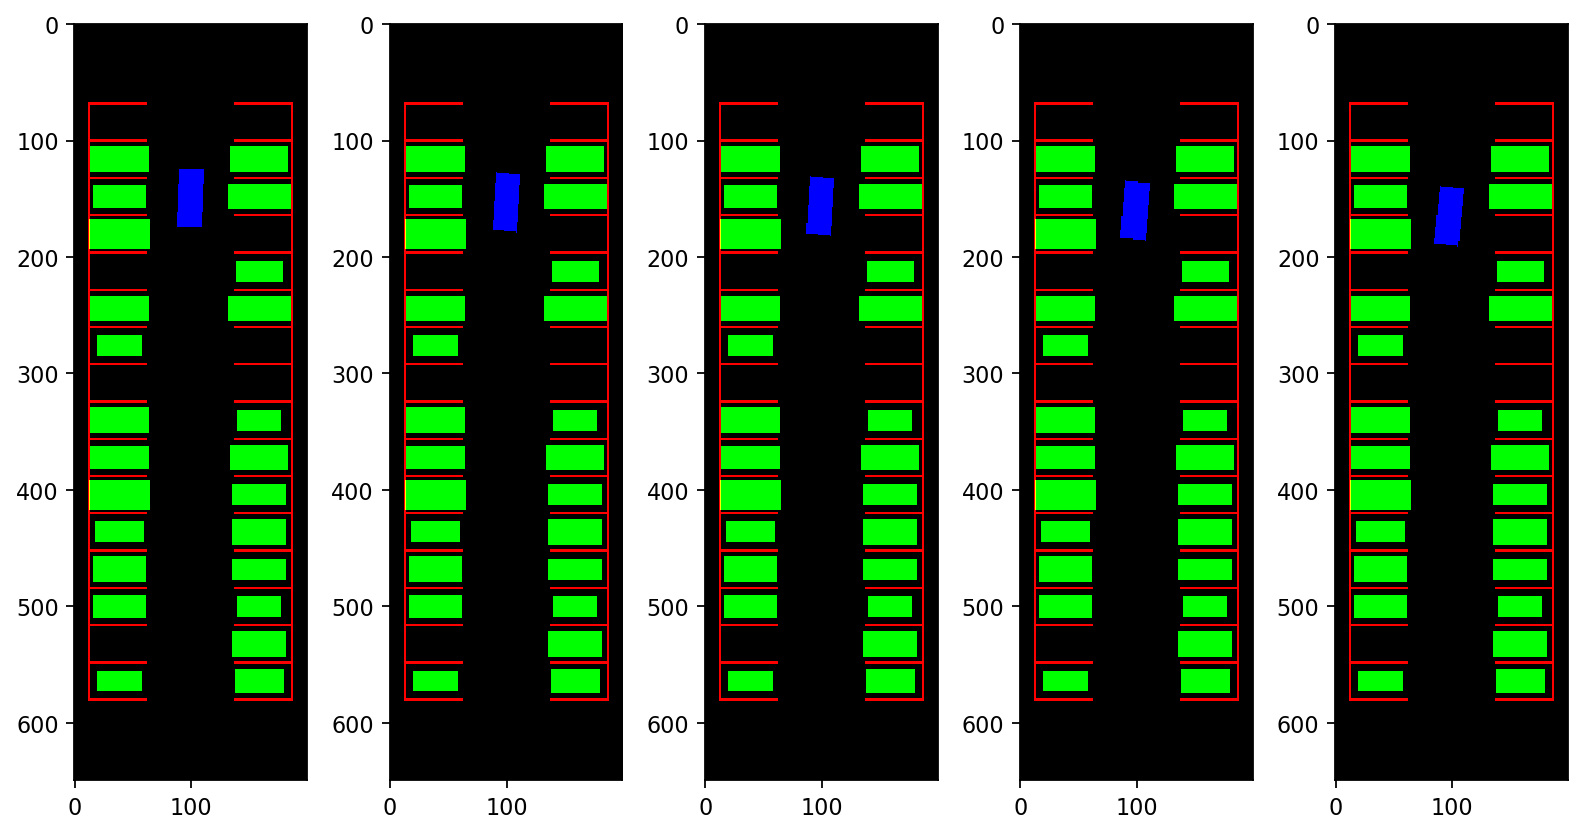

"\n# For debugging: see an arbitrary snippet from the generated tfrecord.\nimage, feature, label, goal, count = read_tfrecord([file_location])\n\nplt.figure(figsize=(10, 10), dpi=160, facecolor='w', edgecolor='k')\nfor i in range(Nhist):\n    plt.subplot(1, Nhist, i+1)\n    plt.imshow(image.numpy()[0, i, :, :, :])\nplt.tight_layout()\nplt.show()\n"

In [7]:

# For visualization/debugging: see the first snippet of data.
for k in range(5):
    print('Instance', k)
    plt.figure(figsize=(10, 10), dpi=160, facecolor='w', edgecolor='k')
    for i in range(Nhist):
        plt.subplot(1, Nhist, i+1)
        plt.imshow(img_hists_batch[k, i, :, :, :])
    plt.tight_layout()
    plt.show()

'''
# For debugging: see an arbitrary snippet from the generated tfrecord.
image, feature, label, goal, count = read_tfrecord([file_location])

plt.figure(figsize=(10, 10), dpi=160, facecolor='w', edgecolor='k')
for i in range(Nhist):
    plt.subplot(1, Nhist, i+1)
    plt.imshow(image.numpy()[0, i, :, :, :])
plt.tight_layout()
plt.show()
'''